In [48]:
!pip install shap

In [49]:
!pip install xgboost

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import tree
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve

In [51]:
df = pd.read_csv('drive/MyDrive/df_total.csv', skiprows=0, low_memory=False)
#df = df.drop(columns = ['NU_IDADE_N'])

In [52]:
df

,SG_UF,NU_IDADE_N,CRITERIO,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,CHIK
0,12,27.0,Laboratorial,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,12,19.0,Laboratorial,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,12,61.0,Laboratorial,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0
3,12,41.0,EpiClinico,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0
4,12,36.0,EpiClinico,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747829,17,24.0,Laboratorial,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
4747830,17,68.0,Laboratorial,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1
4747831,17,33.0,Laboratorial,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1
4747832,17,4.0,EpiClinico,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1


In [53]:
df = pd.concat([pd.get_dummies(df['SG_UF']), df], axis = 1)

In [54]:
df_lab = df[df['CRITERIO'] == 'Laboratorial']
df_lab = df_lab.reset_index(drop = True)
df_epi = df[df['CRITERIO'] == 'EpiClinico']
df_epi = df_epi.reset_index(drop = True)
df_lab = df_lab.drop(columns = ['CRITERIO', 'SG_UF'])
df_epi = df_epi.drop(columns = ['CRITERIO', 'SG_UF'])

In [55]:
df_epi.columns

Index([          11,           12,           13,           14,           15,
                 16,           17,           21,           22,           23,
                 24,           25,           26,           27,           28,
                 29,           31,           32,           33,           35,
                 41,           42,           43,           50,           51,
                 52,           53, 'NU_IDADE_N',      'FEBRE',    'MIALGIA',
         'CEFALEIA',   'EXANTEMA',     'VOMITO',     'NAUSEA', 'DOR_COSTAS',
       'CONJUNTVIT',    'ARTRITE',  'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA',
             'LACO',  'DOR_RETRO',       'CHIK'],
      dtype='object')

In [56]:
df_epi.columns[0:41]

Index([          11,           12,           13,           14,           15,
                 16,           17,           21,           22,           23,
                 24,           25,           26,           27,           28,
                 29,           31,           32,           33,           35,
                 41,           42,           43,           50,           51,
                 52,           53, 'NU_IDADE_N',      'FEBRE',    'MIALGIA',
         'CEFALEIA',   'EXANTEMA',     'VOMITO',     'NAUSEA', 'DOR_COSTAS',
       'CONJUNTVIT',    'ARTRITE',  'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA',
             'LACO'],
      dtype='object')

In [57]:
df_lab.columns = df_lab.columns.astype(str)
df_epi.columns = df_epi.columns.astype(str)

In [58]:
X = df_lab.iloc[:,0:42]
y = df_lab.iloc[:,42]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [59]:
print('Train: ', y_train.shape, sum(y_train == 1), sum(y_train == 0))
print('Test: ', y_test.shape, sum(y_test == 1), sum(y_test == 0))
print('Validation: ', y_val.shape, sum(y_val == 1), sum(y_val == 0))

Train:  (745590,) 24068 721522
Test:  (559193,) 18051 541142
Validation:  (559193,) 18051 541142


### Logistic regression

In [60]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict_proba(X_train)[:,1]
fpr_1, tpr_1, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8983077087868403


<BarContainer object of 42 artists>

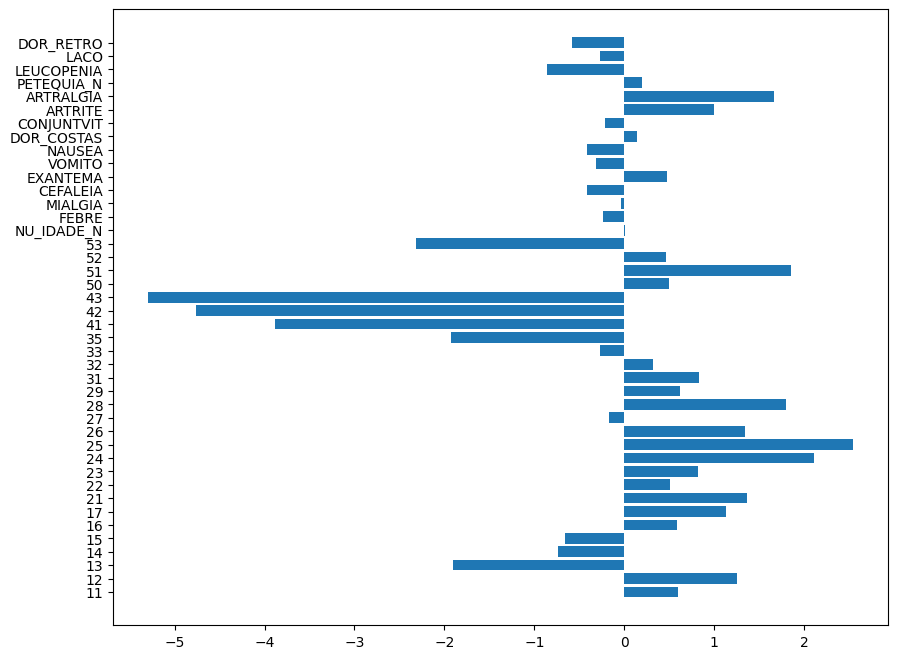

In [61]:
plt.figure(figsize = (10,8))
plt.barh(X_train.columns, logreg.coef_.flatten())

<BarContainer object of 42 artists>

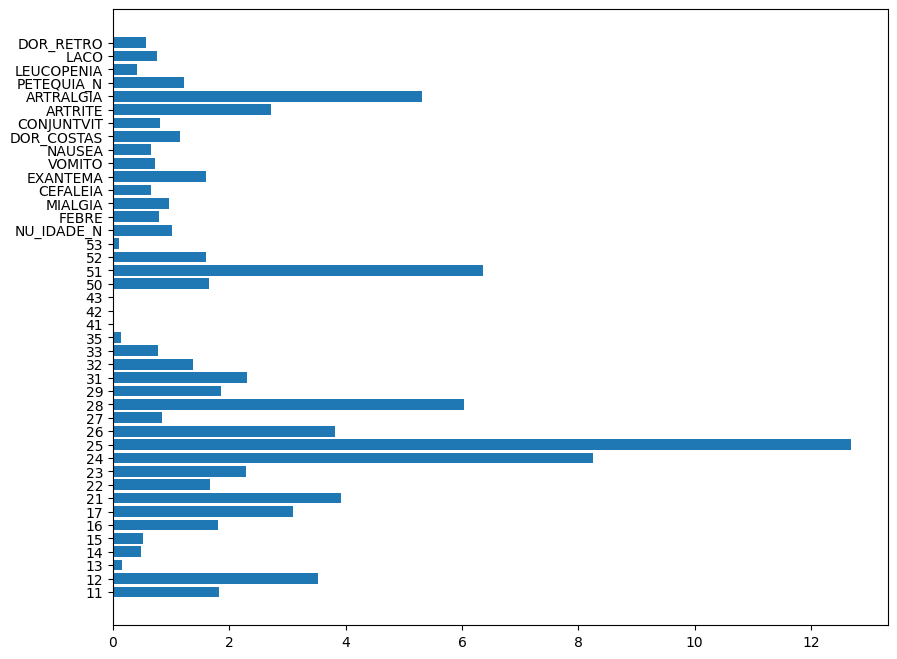

In [62]:
plt.figure(figsize = (10,8))
plt.barh(X_train.columns, np.exp(logreg.coef_.flatten()))

### Random Forest

In [35]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_2, tpr_2, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.9281799427743489


<BarContainer object of 41 artists>

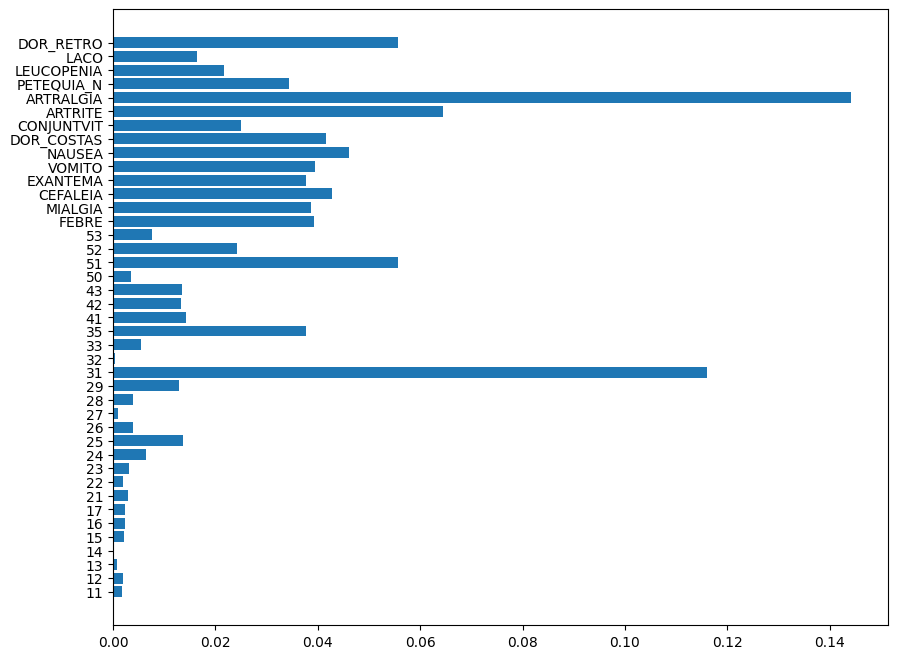

In [ ]:
plt.figure(figsize = (10,8))
plt.barh(X_train.columns, rfc.feature_importances_)

### XGBoost

In [ ]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train, y_train)
y_pred_train = clx.predict_proba(X_train)[:,1]
fpr_3, tpr_3, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.9106982418158801


<BarContainer object of 41 artists>

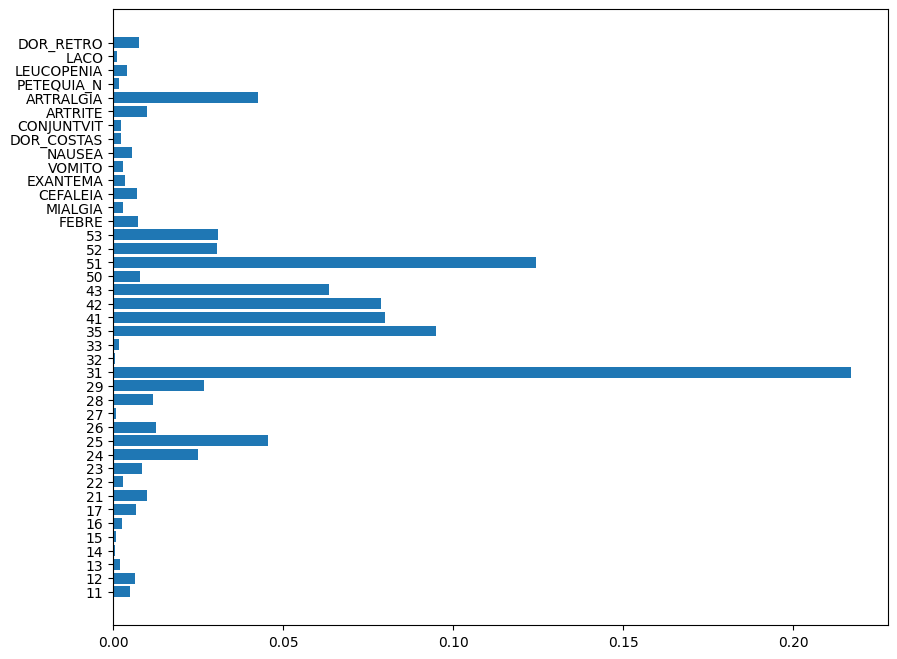

In [ ]:
plt.figure(figsize = (10,8))
plt.barh(X_train.columns, clx.feature_importances_)

### Training with subsampling

In [13]:
num_train_chik = sum(y_train == 1)
ind_train_chik = (y_train == 1)

In [14]:
X_train_chik = X_train.loc[ind_train_chik]
y_train_chik = y_train.loc[ind_train_chik]
X_train_chik = X_train_chik.reset_index(drop = True)
y_train_chik = y_train_chik.reset_index(drop = True)

In [15]:
ind_train_denv = (y_train == 0)

In [16]:
X_train_denv = X_train.loc[ind_train_denv]
y_train_denv = y_train.loc[ind_train_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.reset_index(drop = True)

In [17]:
indexes_denv = np.random.randint(0,X_train_denv.shape[0],num_train_chik)
X_train_denv = X_train_denv.loc[indexes_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.loc[indexes_denv]
y_train_denv = y_train_denv.reset_index(drop = True)

In [18]:
X_train_2 = pd.concat([X_train_denv, X_train_chik])
y_train_2 = pd.concat([y_train_denv, y_train_chik])

In [19]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train_2, y_train_2)
y_pred_train = logreg.predict_proba(X_train_2)[:,1]
fpr_5, tpr_5, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.8981672223282717


In [20]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_2 ,y_train_2)
y_pred_train = rfc.predict_proba(X_train_2)[:,1]
fpr_6, tpr_6, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.9352935849672397


In [21]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train_2, y_train_2)
y_pred_train = clx.predict_proba(X_train_2)[:,1]
fpr_7, tpr_7, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.9145894772301701


In [22]:
plt.plot(fpr_1, tpr_1, label = 'LogReg')
plt.plot(fpr_5, tpr_5, label = 'LogReg Undersampling')
plt.plot(fpr_2, tpr_2, label = 'RF')
plt.plot(fpr_6, tpr_6, label = 'RF Undersampling')
plt.plot(fpr_3, tpr_3, label = 'XGB')
plt.plot(fpr_7, tpr_7, label = 'XGB Undersampling')
plt.legend()
plt.show()

NameError: name 'fpr_1' is not defined

### RandomizedSearchCV for RF

In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50, 100, 200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 10, 20, 50, 100, 200]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

In [24]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'roc_auc',
                               cv = 5,
                               verbose=3,
                               random_state=0,
                               n_jobs = -1)

In [26]:
rf_random.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [1, 2, 10, 20, 50,
                                                             100, 200],
                                        'min_samples_split': [2, 5, 10, 20, 50,
                                                              100, 200],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0, scoring='roc_auc', verbose=3)

In [27]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_split=50, n_estimators=600)

In [28]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 50,
 'min_samples_leaf': 1,
 'max_depth': 30}

In [29]:
rf_random.best_score_

0.9035611903007528

<BarContainer object of 41 artists>

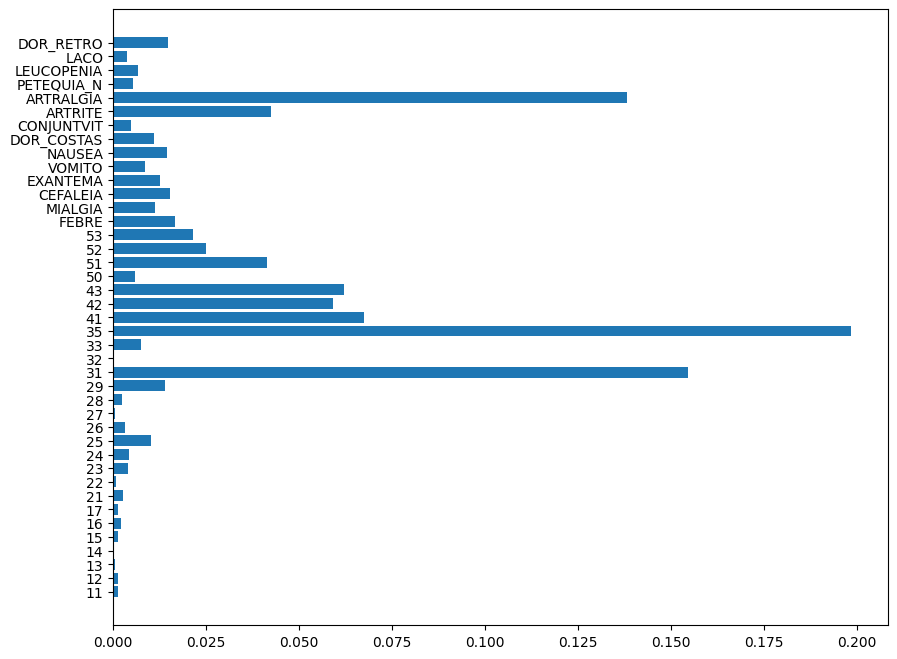

In [30]:
plt.figure(figsize = (10,8))
plt.barh(X_train_2.columns, rf_random.best_estimator_.feature_importances_)

In [ ]:
explainer = shap.Explainer(rf_random.best_estimator_)
shap_values = explainer(X_train_2)

shap.plots.beeswarm(shap_values)

#### Choosing thresholds

In [23]:
rf_random = RandomForestClassifier(n_estimators = 600,
 min_samples_split = 50,
 min_samples_leaf = 1,
 max_depth = 30,
                                   random_state = 0)

In [37]:
rf_random.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=50, n_estimators=600,
                       random_state=0)

In [39]:
y_val_pred = rf_random.predict(X_val)
y_val_proba = rf_random.predict_proba(X_val)[:,1]

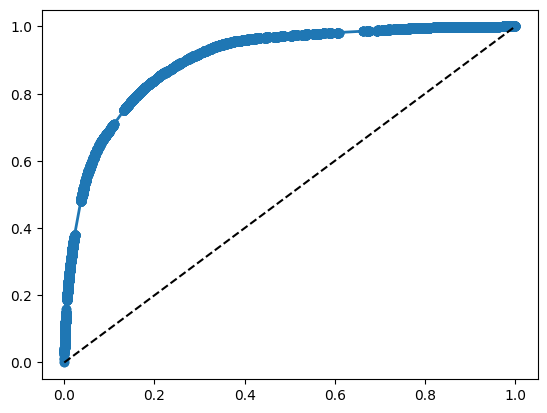

In [40]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label = 1)
plt.plot(fpr, tpr, '-o', linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

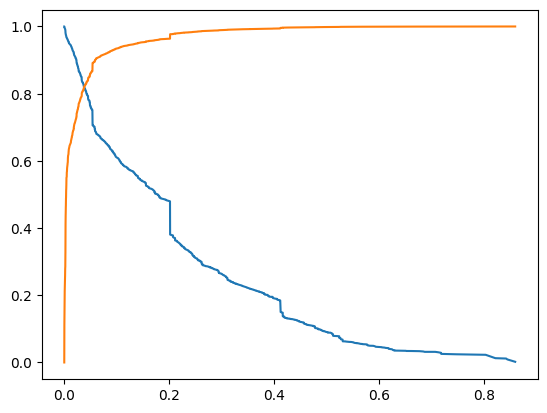

In [41]:
plt.plot(thresholds, tpr)
plt.plot(thresholds, 1 - fpr)

In [42]:
np.argmin(abs(tpr-0.8))

7884

In [43]:
thr_opt = thresholds[7653]

In [44]:
y_pred_proba = rf_random.predict_proba(X_test)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [45]:
confusion_matrix(y_test, y_pred_final)

array([[457539,  83603],
       [  3906,  14145]])

In [46]:
roc_auc_score(y_test, y_pred_final)

0.8145597256530298